## Analyzing full sweep, sub3 n=3

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import gvar as gv
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import lsqfit # WARNING: lsqfit 12.0 appears to be broken. `python3 -m pip install lsqfit==11.8`

from z2_sim.src.NumericsPython.Analysis.fourieranalysis import fourier_ana
from z2_sim.src.QuantumCircuits.Cirq_Code import io

In [2]:
%load_ext autoreload
%autoreload 2

### The data management is yucky.

Each noiseless simulation can basically be performed locally on my laptop. These simulations have very few moving parts: The noiseless simulation campaign is entirely specified by the set of dt's, betas, and grid sizes n. These sweeps are stored in arrays with the following shape (which implies what each element corresponds to):

`(len(jcoup_arr), len(dt_arr), trotter_steps, n, n)`

The $\epsilon=0$ noisy simulations are only mildly more expensive and are optimally simulated on CPU because they only have unitary noise (and so support intermediate state vector simulation). So this specific slice of the noisy simulation campaign is stored in a single output file.

The $\epsilon \neq 0$ noisy simulations are extremely expensive, and every output of the form `(n_trotter, n, n)` is saved into a different output file for compatibility with our HTCondor workflow. These are then collected using `CondorCollector` into a single array for bulk analysis. The collector outputs an array with shape

`(nprocs, len(j_sweep), len(dt_sweep), len(zeta_sweep), len(eps_sweep), trotter_steps, n, n)`

which implies what each axis element corresponds to :).

In [4]:
noiseless_directory = "./results/noiseless"
flag = 'obc'
ns = [3]

# Load the noiseless data into a single dictionary that can be passed to `fourier_ana`
noiseless_data = {}
noiseless_tag = "control"


dts = [0.25]

# Due to commandline inputs the J's for noisy simulation have limited precision. So here
# we just confirm that all our simulations had consistent betas.
j_sweep_control = np.load( os.path.join(noiseless_directory, io.make_physical_params_sweep_fname(noiseless_tag, 'jcoup')))
j_sweep = np.asarray([0.714285, 0.625, .555556])
assert np.allclose(j_sweep, j_sweep_control, atol=1e-5, rtol=1e-4)

for n in ns:
    noiseless_subdirectory = os.path.join(noiseless_directory, f"{n}/")
    noiseless_fname = f'noiseless_parameter_sweep_{noiseless_tag}_results_n{n}_{flag}.npy'
    arr = np.load(os.path.join(noiseless_subdirectory, noiseless_fname))[:,:,:50,:,:]
    noiseless_data[(flag, n)] = arr
        
        
# For noisy data, construct a sequence of such dictionaries
noisy_directory = './results/noisy'
beta_sweep = 1 / j_sweep
assert np.allclose(beta_sweep, [1.4, 1.6, 1.8])
beta_sweep = [1.4, 1.6, 1.8]
beta_keys = np.round(beta_sweep, decimals=6)

dt = 0.25
eps_sweep = [0, 0.001, 0.002, 0.003, 0.004, 0.005]
eps_sweep_trunc = [0.001, 0.002, 0.003, 0.004, 0.005]
n_trajectories = 100
tstart = 1
tstop = 51
trotter_steps = tstop - tstart
zeta_sweep = [0, 150000, 300000, 450000, 600000, 750000]
nprocs = 10


# # Load the data into separate dictionaries that can be passed to `fourier_ana`
# # This way, any element of this data sequence can be treated on equal footing 
# # with a noiseless data array.
noisy_data_grid = [[{} for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]

for n in ns:
    noisy_subdirectory = os.path.join(noisy_directory, f"{n}/")
    collector = io.CondorCollector(
        path=noisy_subdirectory,
        nprocs=nprocs,
        n=n,
        j_sweep=j_sweep,
        dt_sweep=[dt],
        trotter_intervals=[(tstart, tstop)],
        zeta_sweep=zeta_sweep,
        eps_sweep=eps_sweep_trunc, # don't look for eps=0
        r=n_trajectories,
    )

    #!! epsilon dependence stored in the 4th index
    #!! shot dependence stored in the 0th index
    data_arr = collector.collect_htcondor_outputs()
    for i in range(len(zeta_sweep)):
        for j in range(len(eps_sweep_trunc)):
            # (nprocs, len(j_sweep), len(dt_sweep), len(zeta_sweep), len(eps_sweep), trotter_steps, n, n)
            noisy_data_grid[i][j+1][('obc', n)] = data_arr[:,:,:,i,j,:,:,:].mean(axis=0)

# Concatenate with the unitary eps=0 data
# These are in a particular order. Don't worry about it.
noisy_directory = "./results/noisy"
noisy_data = {}
noisy_tag = "20210921d"

zetas_zeroeps = np.load(os.path.join(noisy_directory, io.make_noisy_params_sweep_fname(noisy_tag, 'zeta')))
assert np.allclose(zetas_zeroeps, zeta_sweep)
for n in ns:
    noisy_subdirectory = os.path.join(noisy_directory, f"{n}/")

    noisy_fname = f'noisy_parameter_sweep_{noisy_tag}_results_n{n}_{flag}.npy'
    data_arr = np.load(os.path.join(noisy_subdirectory, noisy_fname))
    assert data_arr.shape == (len(zeta_sweep), len(beta_sweep), len(dts), trotter_steps, n, n)
    for i in range(len(zeta_sweep)):
        noisy_data_grid[i][0][('obc', n)] = data_arr[i]


#### Verify that noisy results are seeded differently!

The fact that the plot below has many lines means that each noisy simulation was different. This was a concern of mine that seeds might get duplicated during the condor submission process.

### Perform the fourier analysis and mass analysis on each dataset

Noiseless datset followed by noisy dataset at each noise parameter.

In [5]:
bc_flags = ['obc']
noiseless_fourier = fourier_ana(
    results=noiseless_data, 
    bc_flags=bc_flags, 
    grid_sizes=ns, 
    dts=dts, 
    betas=beta_sweep, 
    n_trotter=50, 
    samp_rate = 2048, 
    nboot = 200)

noisy_fourier_grid = [[None for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]
for i in range(len(zeta_sweep)):
    for j in range(len(eps_sweep)):
        noisy_data = noisy_data_grid[i][j]
        noisy_fourier = fourier_ana(
            results=noisy_data, 
            bc_flags=bc_flags, 
            grid_sizes=ns, 
            dts=dts, 
            betas=beta_sweep, 
            n_trotter=50, 
            samp_rate = 2048, 
            nboot = 200
        )
        noisy_fourier_grid[i][j] = noisy_fourier


In [6]:
noisy_data_grid[-1][2][('obc', n)][2, 0,:,1,1].real

array([ 0.73256933,  0.58356534,  0.26505933, -0.05865199, -0.1246922 ,
       -0.26720659, -0.34018655, -0.20383219, -0.08650116,  0.00379838,
        0.06490663,  0.07672597,  0.07819896,  0.05398862,  0.05922644,
        0.05764269,  0.06310219,  0.07120302,  0.06776657,  0.07570032,
        0.08588561,  0.08456575,  0.0630836 ,  0.04318995,  0.01806867,
        0.00986054,  0.00450738, -0.00391057, -0.00534763,  0.00099105,
        0.01320209,  0.02121845,  0.02771072,  0.03338411,  0.03449999,
        0.03013405,  0.02581858,  0.02253454,  0.01729983,  0.01934589,
        0.01844689,  0.01468019,  0.01802626,  0.01311727,  0.01290344,
        0.0118458 ,  0.01067266,  0.0125223 ,  0.01113119,  0.01332941])

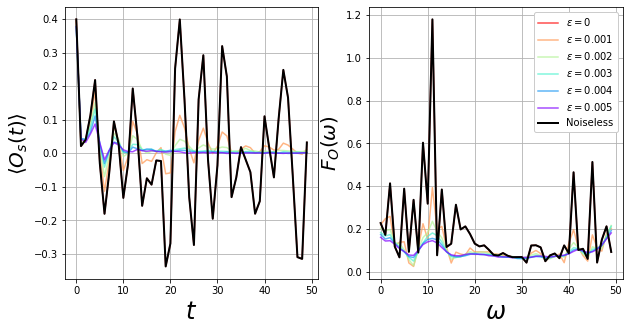

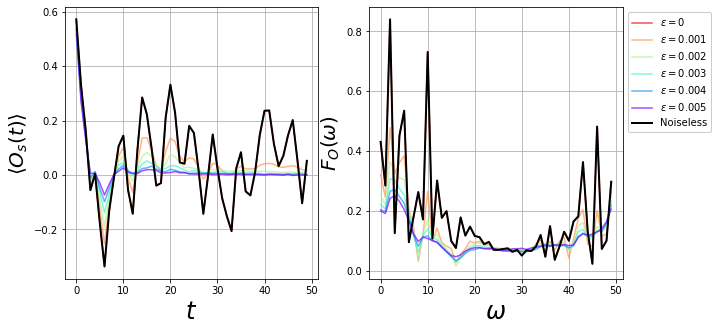

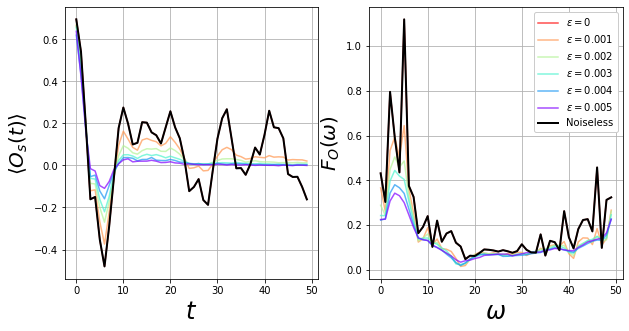

In [20]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]))
for k in range(3):
#     k = 2
    zeta_idx = 0
    beta = beta_sweep[k]
    trotter_steps = 50
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot time series
    # axes: [beta, dt, trotter_step, n, n]
    # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
    for i, eps in enumerate(eps_sweep):
        y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
        axes[0].plot(range(trotter_steps), y, label=f'{eps}', c=colors[i], alpha=0.7)    
    # Plot spectrum
    for i, eps in enumerate(eps_sweep):
        y = noisy_fourier_grid[zeta_idx][i][0][('obc', 3, 0.25, beta)]
        axes[1].plot(range(trotter_steps), y, label=r"$\epsilon=$" + f'{eps}', c=colors[i], alpha=0.7)

    axes[0].plot(noiseless_data[('obc', 3)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=2)
    axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=2)

    axes[0].set_ylabel(r"$\langle O_s(t) \rangle$", size=20)
    axes[0].set_xlabel(r"$t$", size=24)
    axes[1].set_xlabel(r"$\omega$", size=24)
    axes[1].set_ylabel(r"$F_O(\omega) $", size=20)

    axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1)
    for ax in axes:
        ax.grid()

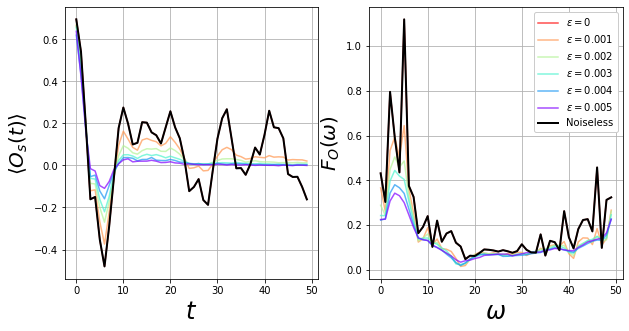

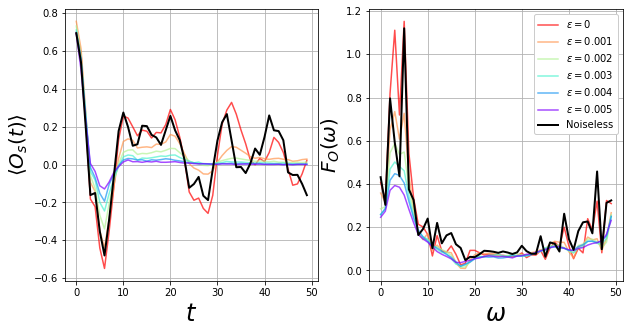

In [7]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]))
k = 2
beta = beta_sweep[k]
trotter_steps = 50
for zeta_idx in [0, -1]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot time series
    # axes: [beta, dt, trotter_step, n, n]
    # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
    for i, eps in enumerate(eps_sweep):
        y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
        axes[0].plot(range(trotter_steps), y, label=f'{eps}', c=colors[i], alpha=0.7)    
    # Plot spectrum
    for i, eps in enumerate(eps_sweep):
        y = noisy_fourier_grid[zeta_idx][i][0][('obc', 3, 0.25, beta)]
        axes[1].plot(range(trotter_steps), y, label=r"$\epsilon=$" + f'{eps}', c=colors[i], alpha=0.7)

    axes[0].plot(noiseless_data[('obc', 3)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=2)
    axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=2)

    axes[0].set_ylabel(r"$\langle O_s(t) \rangle$", size=20)
    axes[0].set_xlabel(r"$t$", size=24)
    axes[1].set_xlabel(r"$\omega$", size=24)
    axes[1].set_ylabel(r"$F_O(\omega) $", size=20)

    axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1)
    for ax in axes:
        ax.grid()
# fig.savefig("../figures/sample_epsilon_timeseries.pdf")
    

## Bulk analysis

The primary analysis that we can apply en masse is to compare $\Delta E_{01}$ as a function of $dt$ across different noise strengths.

### Start by looking at mass versus dt

The following is less condensed but can maybe reveal trends in the noise behavior.

In [12]:
rel_err_grid = np.zeros((len(beta_sweep), len(zeta_sweep), len(eps_sweep)))
n = 3
dt = 0.25
for i, betakey in enumerate(beta_keys):

    # Plot noiseless energy vs dt
    ens = noiseless_fourier[1]
    noiseless_y = np.abs(np.array(gv.mean(ens[('obc', n, dt, betakey)])))

    for j, zeta in enumerate(zeta_sweep):
        for k, eps in enumerate(eps_sweep):
            ens_noisy = noisy_fourier_grid[j][k][1]

            # Compute and plot absolute error
            noisy_y = np.abs(np.array(gv.mean(ens_noisy[('obc', n, dt, betakey)])))
            noisy_yerr = gv.sdev(ens_noisy[('obc', n, dt, betakey)])

            # Plot relative error
            rel_err = (noisy_y - noiseless_y) / noiseless_y
            rel_err_grid[i,j,k] = rel_err
        
    # there's actually a 2% or so statistical error in the bootstrapping pipeline
    # so just force this
    rel_err_grid[i,0,0] = 0
        

In [13]:
rel_err_grid[0]

array([[ 0.        ,  0.        ,  0.63727273,  2.25136364,  1.61363636,
         1.79863636],
       [ 0.        , -0.03272727,  0.76272727,  2.16681818,  2.02909091,
         1.82136364],
       [ 0.        , -0.70772727,  0.41045455,  1.93227273,  2.26227273,
         1.80863636],
       [-0.81      , -0.81818182, -0.15636364,  1.86727273,  1.81909091,
         1.76227273],
       [-0.81818182, -0.81818182, -0.21409091,  1.46818182,  1.36318182,
         1.55818182],
       [-0.78909091, -0.81818182, -0.38136364,  1.04454545,  1.11590909,
         1.80727273]])

In [14]:
rel_err_grid[1]

array([[0.    , 0.0075, 0.105 , 0.3075, 0.3725, 0.9675],
       [0.    , 0.    , 0.1125, 0.3675, 0.4325, 0.7   ],
       [0.    , 0.0225, 0.215 , 0.335 , 0.445 , 0.45  ],
       [0.12  , 0.0975, 0.1875, 0.365 , 0.375 , 0.5525],
       [1.4925, 0.4525, 0.2625, 0.4   , 0.425 , 0.5375],
       [1.5   , 0.6975, 0.2575, 0.435 , 0.55  , 0.49  ]])

In [15]:
rel_err_grid[2]

array([[ 0.   , -0.016, -0.291, -0.341, -0.328, -0.339],
       [ 0.   , -0.042, -0.341, -0.35 , -0.34 , -0.338],
       [ 0.   , -0.096, -0.341, -0.341, -0.349, -0.347],
       [ 0.   , -0.226, -0.34 , -0.351, -0.324, -0.342],
       [ 0.   , -0.208, -0.355, -0.362, -0.349, -0.337],
       [-0.038, -0.258, -0.366, -0.371, -0.322, -0.344]])

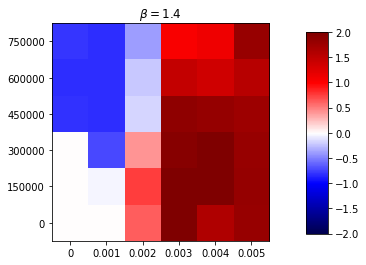

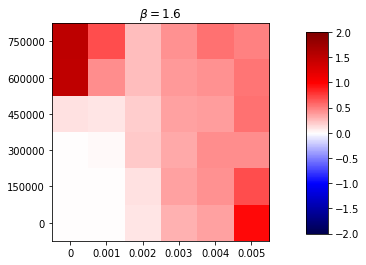

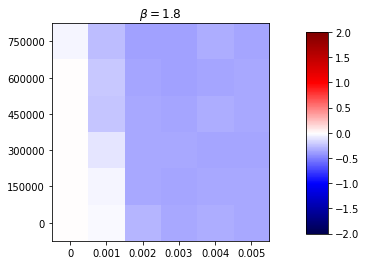

In [16]:
for i, beta in enumerate(beta_sweep):
    fig, ax = plt.subplots()
    im = ax.imshow(rel_err_grid[i], cmap="seismic", vmin=-2, vmax=2, origin='lower')
    ax.set_title(r"$\beta=$" + f"{beta}")
    ax.set_xticks(range(len(eps_sweep)))
    ax.set_xticklabels(eps_sweep)
    ax.set_yticks(range(len(zeta_sweep)))
    ax.set_yticklabels(zeta_sweep)
    
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

### Demo plot

In [22]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

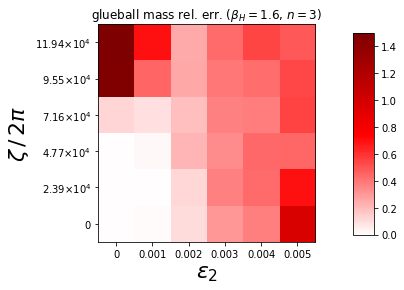

In [23]:
i = 1
beta = beta_sweep[i]
fig, ax = plt.subplots()
cmap = truncate_colormap(plt.get_cmap('seismic'), minval=0.5, maxval=1)
im = ax.imshow(rel_err_grid[i], cmap=cmap, vmin=0, origin='lower')
ax.set_xticks(range(len(eps_sweep)))
ax.set_xticklabels(eps_sweep)
ax.set_yticks(range(len(zeta_sweep)))
zeta_labs = ["0"] + [f"{zeta/(1e4 * np.pi * 2):3.2f}"+r"$\times 10^4$" for zeta in zeta_sweep[1:]]
ax.set_yticklabels(zeta_labs)

betastr = r"$\beta_H=$"+f"{beta}"
nstr = r"$n=$"+f"{n}"
ax.set_title(f"glueball mass rel. err. ({betastr}, {nstr})")
ax.set_xlabel(r"$\epsilon_2$", size=22)
ax.set_ylabel(r"$\zeta\,/\,2\pi$", size=22)

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("../figures/glueball_err_demo.pdf", bbox_inches='tight')

In [ ]:
def plot_timeseries(beta, zetalst, eps_lst)

    colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]))
    k = 1
    beta = beta_sweep[k]
    trotter_steps = 50
    for zeta_idx in [0, -1]:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # Plot time series
        # axes: [beta, dt, trotter_step, n, n]
        # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
        for i, eps in enumerate(eps_sweep):
            y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
            axes[0].plot(range(trotter_steps), y, label=f'{eps}', c=colors[i], alpha=0.7)    
        # Plot spectrum
        for i, eps in enumerate(eps_sweep):
            y = noisy_fourier_grid[zeta_idx][i][0][('obc', 3, 0.25, beta)]
            axes[1].plot(range(trotter_steps), y, label=r"$\epsilon=$" + f'{eps}', c=colors[i], alpha=0.7)

        axes[0].plot(noiseless_data[('obc', 3)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=2)
        axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=2)

        axes[0].set_ylabel(r"$\langle O_s(t) \rangle$", size=20)
        axes[0].set_xlabel(r"$t$", size=24)
        axes[1].set_xlabel(r"$\omega$", size=24)
        axes[1].set_ylabel(r"$F_O(\omega) $", size=20)

        axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1)
        for ax in axes:
            ax.grid()

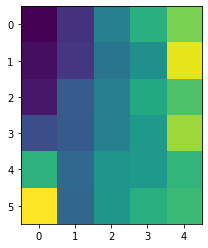

In [22]:
plt.imshow(rel_err_grid[1])

In [16]:
noisy_yerr

0.12566370614359174

[1.28272727]
[1.12681818]
[1.865]
[0.]
[0.]
[0.]
[9.87]
[3.3925]
[0.9025]
[0.]
[0.]
[0.]
[4.24]
[-0.212]
[-0.339]
[-0.016]
[0.]
[0.]


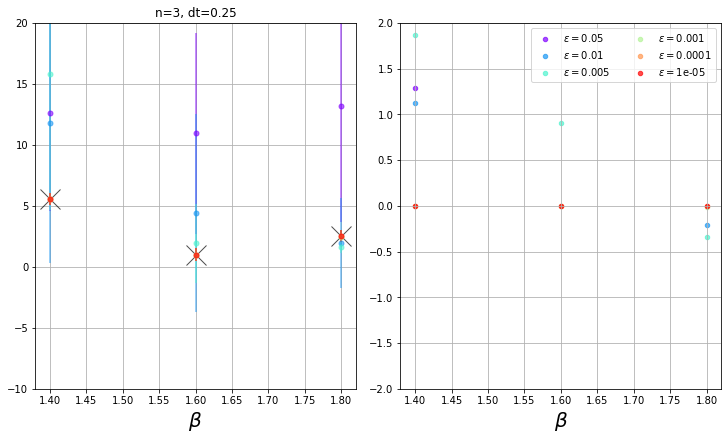

In [92]:
import matplotlib.cm as cm



    
for n in [3]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=False)

    # plot params
    s = 20

    for i, betakey in enumerate(beta_keys):
        colors = [x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]
        colors = (x for x in colors)
        
        # Plot noiseless energy vs dt
        ens = noiseless_fourier[1]
        noiseless_y = np.abs(np.array([gv.mean(ens[('obc', n, dt, betakey)]) / dt for dt in dts]))
        noiseless_yerr = gv.sdev([ens[('obc', n, dt, betakey)] / dt for dt in dts])
        axes[0].errorbar(
            betakey, 
            noiseless_y, 
            yerr=noiseless_yerr, 
            fmt='x', 
            label=f"noiseless" if i == 0 else None, 
            markersize=s,
            alpha=0.7,
            c='k'
        )    
        axes[0].set_title(f"n={n}, dt={dt}")

#         for k, zeta in enumerate(zeta_sweep):
        for j, eps in enumerate(eps_sweep):
#             if eps > 0.001:
#                 continue
            c = next(colors)
            ens_noisy = noisy_fourier_grid[0][j][1]

            # Compute and plot absolute error
            noisy_y = np.abs(np.array([gv.mean(ens_noisy[('obc', n, dt, betakey)]) / dt for dt in dts]))
            noisy_yerr = gv.sdev([ens_noisy[('obc', n, dt, betakey)] / dt for dt in dts])
            axes[0].errorbar(
                betakey, 
                noisy_y, 
                yerr=noisy_yerr, 
                fmt='.', 
                label=r"$\epsilon=$" + f"{eps}" if i == 0 else None, 
                markersize=s/2,
                alpha=0.6,
                c=c
            )   
            # Plot relative error
            rel_err = (noisy_y - noiseless_y) / noiseless_y
            print(rel_err)
            axes[1].scatter(
                betakey, 
                rel_err, 
                marker='.', 
                label=r"$\epsilon=$" + f"{eps}" if i == 0 else None, 
                s=80,
                alpha=0.7,
                color=c
            )   


    axes[0].set_ylim(-10, 20)
    axes[0].grid()
    #     ax.semilogy()
    axes[1].set_ylim(-2, 2)
    axes[1].grid()
    for ax in axes:
        ax.set_xlabel(r"$\beta$", size=20)

    axes[1].legend(ncol=2, bbox_to_anchor=(1, 1))


### Noise strength versus $m(t)$

Here we look at a scalar function of $\xi$; I'm going to start with the benchmark quantity

$$
f(\xi) = || m(\Delta t) - m'(\Delta t) ||_2
$$

and the goal is to find
$$
\text{argmax}_\xi  f(\xi) \, s.t. \, f(\xi) \leq \epsilon
$$
where $m(\Delta t)$ is the vector of masses computed from noiseless simulation and $m'$ corresponds to noisy masses. The motivation for $||\cdot ||_2$ is that we need more than a single value of $m$ to run a fit.

 - A possible sticking point will be the inclusion of $\Delta t = 0.01$, which tends to be very sensitive to $\xi$. I'm going to just exclude that point since it seems unrelieable in general

Text(0.5, 0, '$\\zeta$')

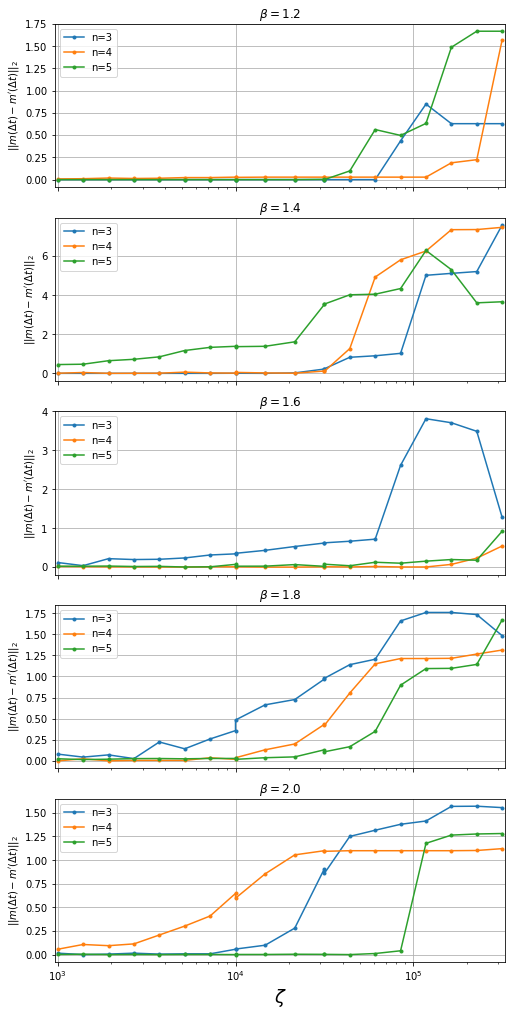

In [40]:
plt.close('all')
dts_trunc = dts[1:]
fig, axes = plt.subplots(len(betas), 1, figsize=(7, 14), constrained_layout=True, sharex=True, sharey=False)

for i, betakey in enumerate(beta_keys):

    for n in [3, 4, 5]:

        ens = noiseless_fourier[1]
        noiseless_y = np.abs(np.array([gv.mean(ens[('obc', n, dt, betakey)]) / dt for dt in dts_trunc]))
        diffs_vs_zeta = []
        zeta_iter = zetas
#         if n == 5:
#             zeta_iter = zetas4
        for j, zeta in enumerate(zeta_iter):
            ens_noisy = noisy_fourier_lst[j][1]
#             if n == 5:
#                 ens_noisy = noisy_fourier_lst_n5[j][1]
            noisy_y = np.abs(np.array([gv.mean(ens_noisy[('obc', n, dt, betakey)]) / dt for dt in dts_trunc]))
            diff_l2 = np.linalg.norm(noiseless_y - noisy_y, ord=2)
            diffs_vs_zeta.append(diff_l2)
        axes[i].plot(zeta_iter, diffs_vs_zeta, label=f"n={n}", marker='.')
        # Consistent across gridsizes
        axes[i].set_xlim(.96*min(zetas), max(zetas)*1.04)
        axes[i].semilogx()
        axes[i].set_ylabel(r"$||m(\Delta t) - m'(\Delta t)||_2$")
        axes[i].set_title(r"$\beta=$" + f"{betakey}")
        axes[i].grid()
        axes[i].legend(loc="upper left")
        
axes[-1].set_xlabel(r"$\zeta$", size=18)
    

In [41]:
len(zetas)

20